In [1]:
import os
import sys
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

prj_dir = os.path.abspath(os.getcwd() + '/..')
print(prj_dir)
sys.path.append(prj_dir)

/Users/raul.sanchez/data_scientia/rulo_mota_omath


In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import shap
from sklearn.model_selection import train_test_split

from src import config
from src.features import X_features
from src.features import banxico_mun_income_remittances

In [3]:
path = os.path.join(
    config.PRJ_DIR,
    'data/interim/cnbv/inclusion_financiera/BD Tenencia Uso EACP Mun.csv')

df = pd.read_csv(path)

feature_list = [
    'captacion__depositos_al_ahorro',
    'captacion__depositos_a_la_vista',
    'captacion__depositos_a_plazo',
    'captacion__tarjetas_de_debito',
    'credito__credito_al_consumo',
    'credito__credito_a_la_vivienda',
    'transacciones__en_tpv',
    'transacciones__en_cajeros_automaticos',
    'captacion__depositos_al_ahorro (2)',
    'captacion__depositos_a_la_vista (2)',
    'captacion__depositos_a_plazo (2)',
    'captacion__tarjetas_de_debito (2)',
    'credito__credito_al_consumo (2)',
    'credito__credito_a_la_vivienda (2)',
    'transacciones__en_tpv (2)',
    'transacciones__en_cajeros_automaticos (2)',
    'clientes_-_sofipo__mujeres', 'clientes_-_sofipo__hombres',
    'socios_-_socap__mujeres', 'socios_-_socap__hombres',
    'total_de_usuarios_-_eacp__mujeres',
    'total_de_usuarios_-_eacp__hombres',
    'captacion__deposito_al_ahorro',
    'captacion__deposito_a_la_vista',
    'captacion__deposito_a_plazo',
    'captacion__tarjeta_debito',
    'captacion__deposito_al_ahorro (2)',
    'captacion__deposito_a_la_vista (2)',
    'captacion__deposito_a_plazo (2)',
    'captacion__tarjeta_debito (2)']

data = X_features.get(df, feature_list)
remittances = banxico_mun_income_remittances.get()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


divide by zero encountered in log1p
invalid value encountered in log1p


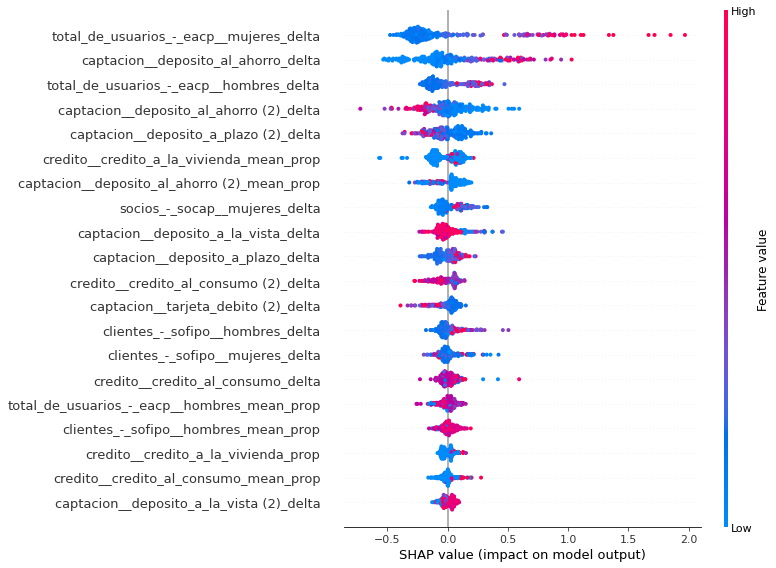

divide by zero encountered in log1p
invalid value encountered in log1p


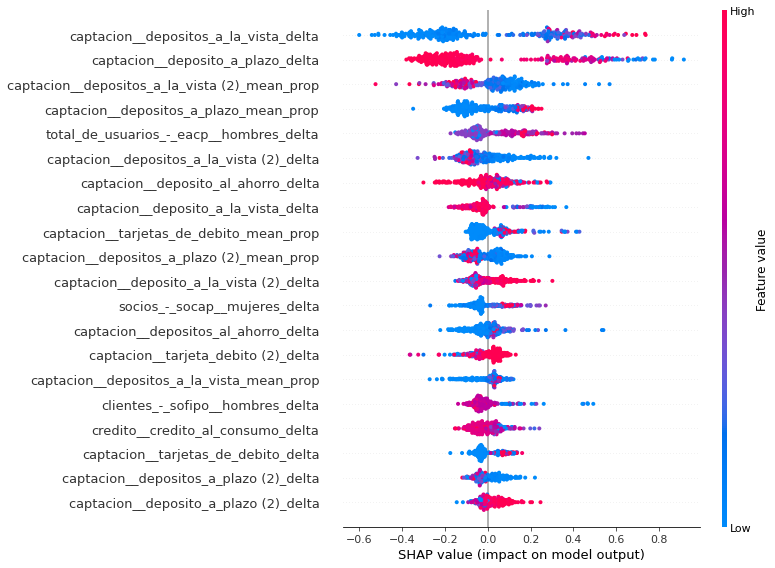

In [11]:
feature_importance, shap_cache = {}, {}
for year, year_data in data.groupby('year'):
    X = year_data.drop(['year', 'mun'], axis=1)
    X.apply(lambda x: np.log1p(x))
    
    year_remittances = remittances[remittances['Year'] == year]
    y = year_remittances['Remittance Amount Million USD log1p']
    
    valid_ids = list(set(X.index).intersection(year_remittances.index))
    
    X, y = X.loc[valid_ids], y.loc[valid_ids]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        train_size=.8)
    
    model = XGBRegressor(
        learning_rate=0.1, 
        max_depth=8, 
        n_estimators=1000)

    model.fit(
        X, y, 
        eval_set=[
            (X_test, y_test)
        ],
        early_stopping_rounds=20,
        verbose=False)
    
    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(
        X_test, 
        check_additivity=False)
    
    features_shap_values = pd.DataFrame(
        shap_values,
        columns=X_test.columns)
    
    features_shap_values_contribution = features_shap_values.abs().sum()
    
    feature_importance[year] = features_shap_values_contribution

    shap.summary_plot(
        shap_values, 
        X_test, 
        max_display=20)
    
    shap_cache[year] = {'X': X_test, 'shap_values': shap_values, 'f_shap_values': features_shap_values}
    
year_importance = pd.DataFrame(feature_importance).T
year_importance_norm = (year_importance.T / year_importance.T.sum()).T

In [17]:
year_importance_stats = pd.DataFrame({
    'mean': year_importance_norm.mean().sort_values(),
    'std': year_importance_norm.std().sort_values(),
    'max': year_importance_norm.max().sort_values()
})

In [18]:
# is_shap_always_greater_than_1 = (year_importance_norm < 0.0001).sum() == 0

# feature_selection = year_importance_stats[(
#     is_shap_always_greater_than_1
# ) & (
#     year_importance_stats['mean'] >= year_importance_stats['mean'].quantile(.5)
# )].sort_values('std').index

In [22]:
top_n = 30
feature_selection = year_importance_stats['max'].sort_values().iloc[-top_n:].index

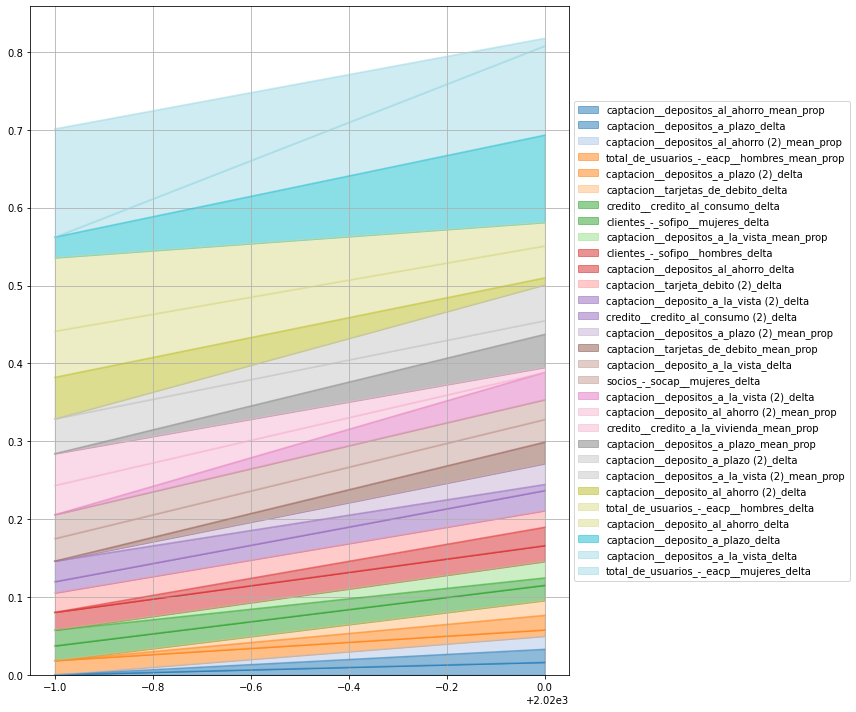

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
year_importance_norm[feature_selection].plot(
    kind='area',
    alpha=.5,
    grid=True,
    stacked=True,
    ax=ax,
    cmap='tab20')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_tight_layout('tight')

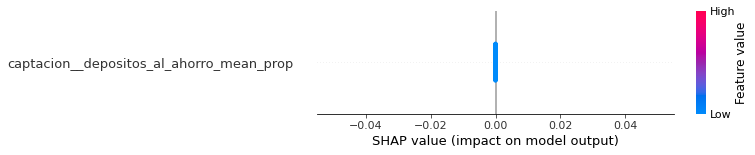

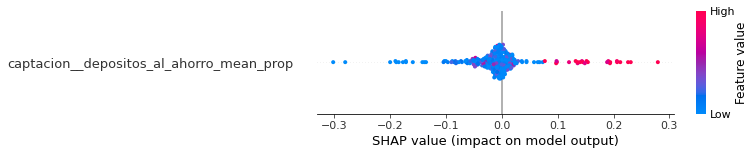

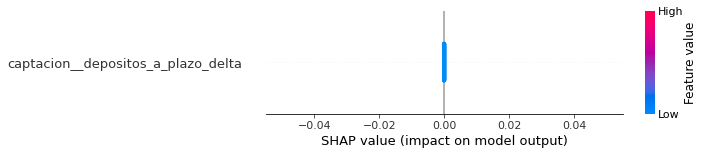

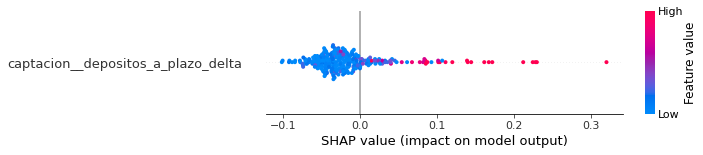

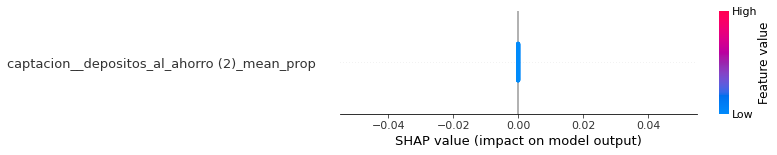

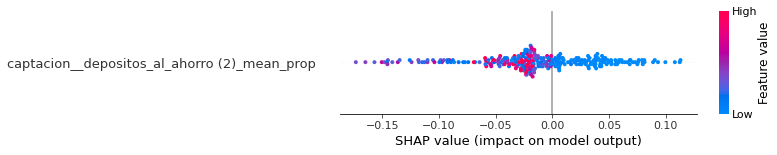

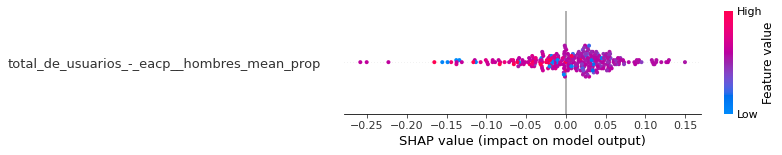

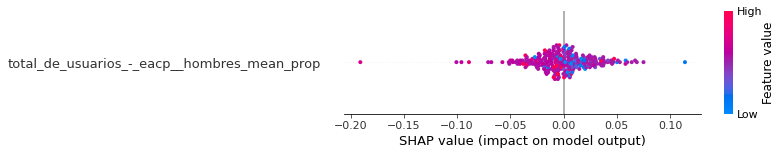

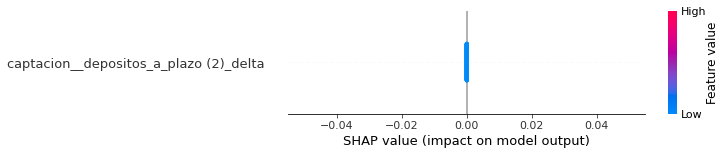

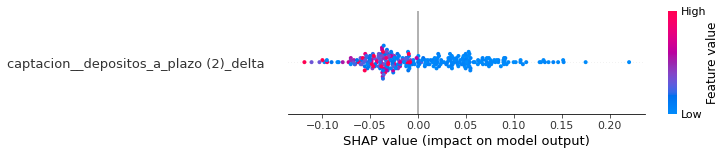

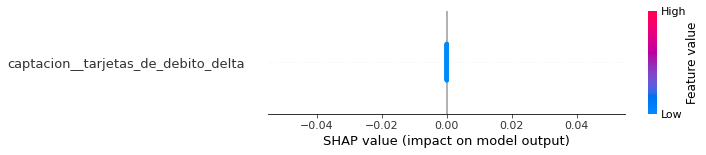

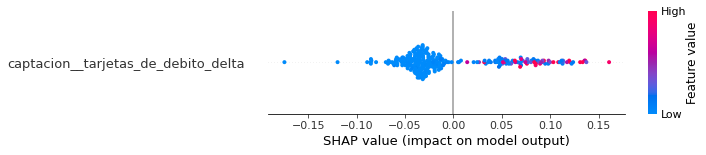

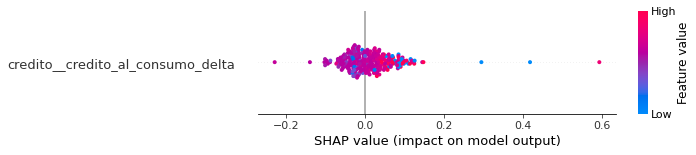

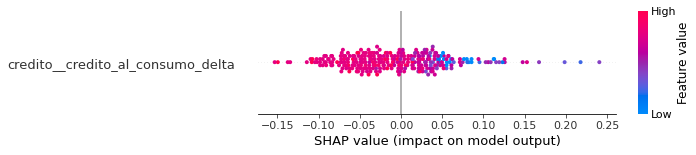

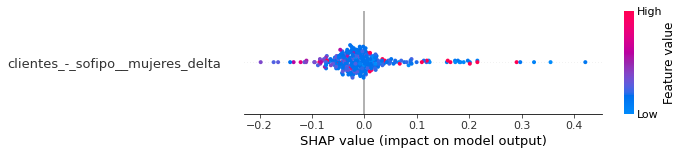

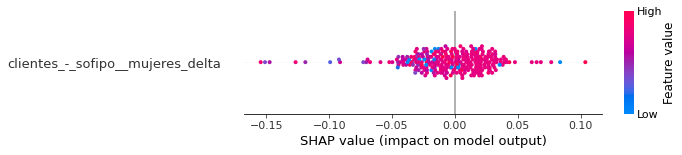

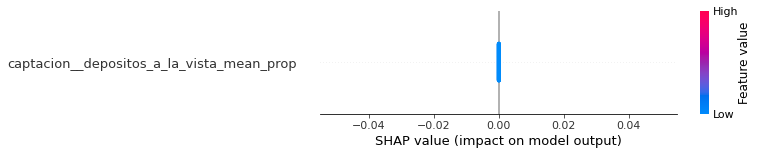

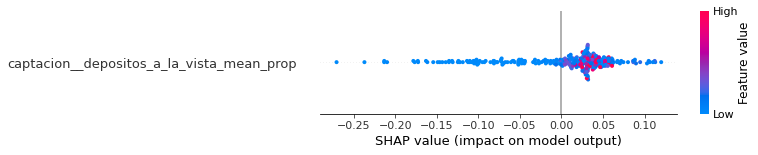

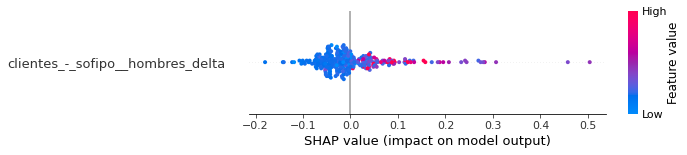

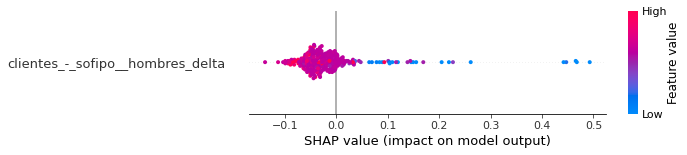

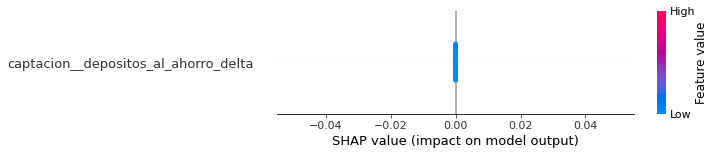

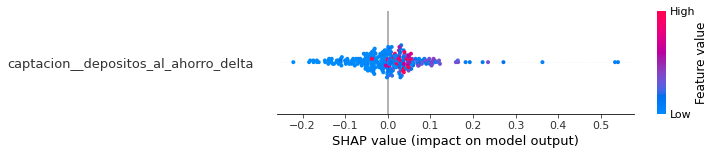

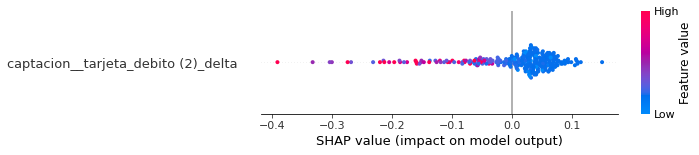

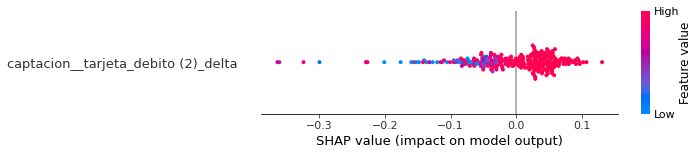

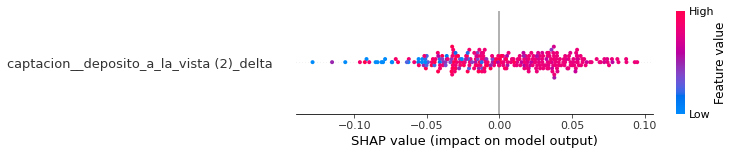

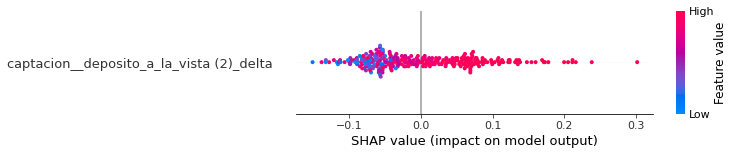

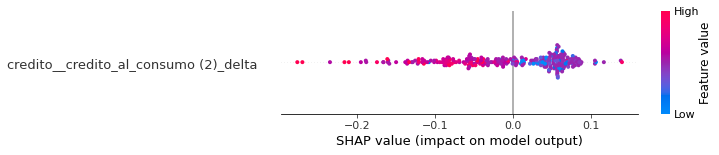

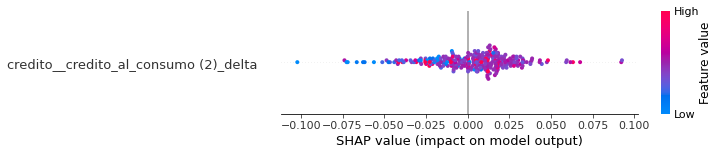

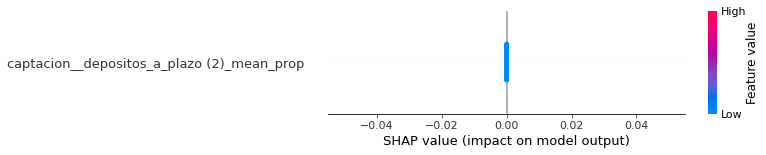

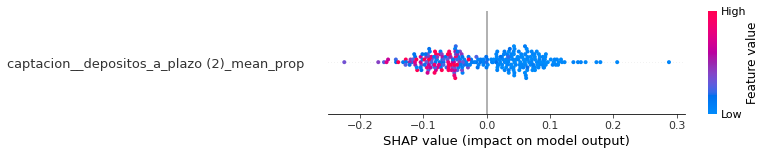

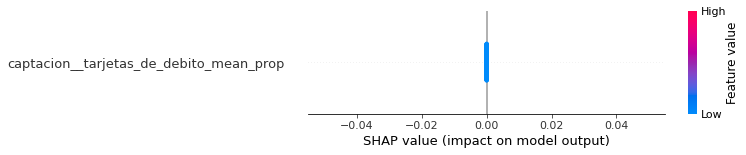

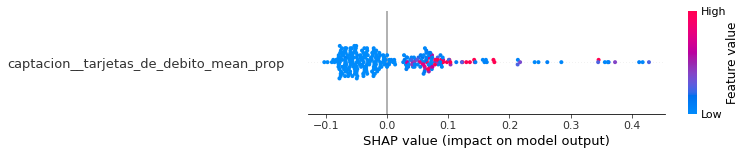

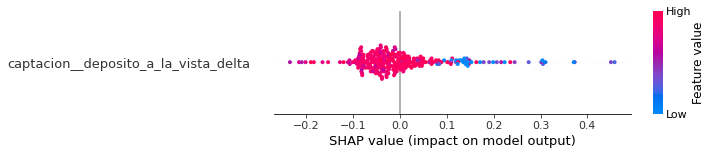

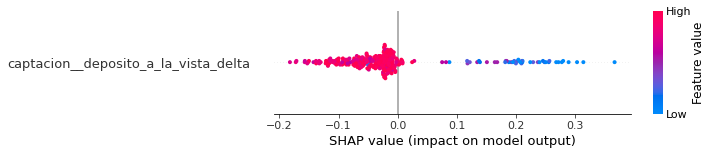

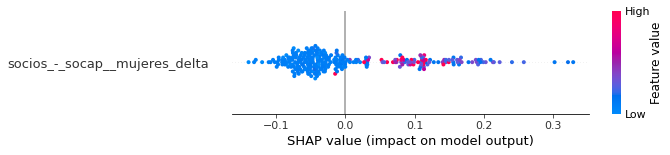

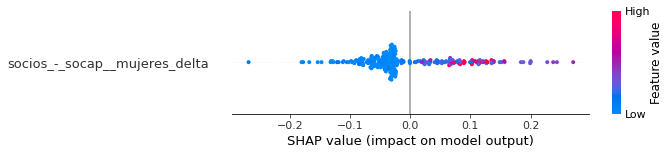

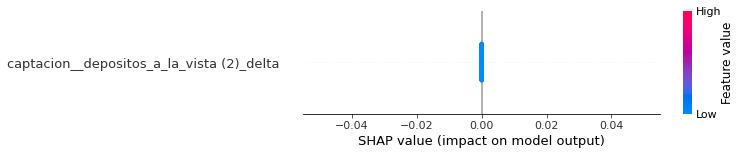

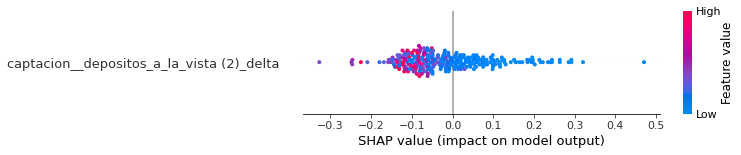

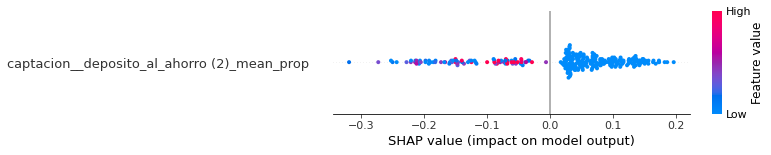

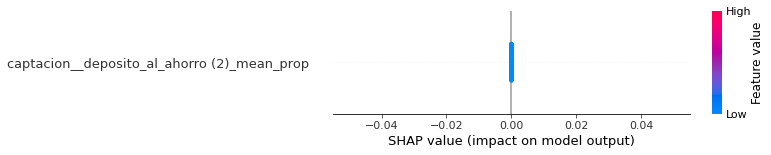

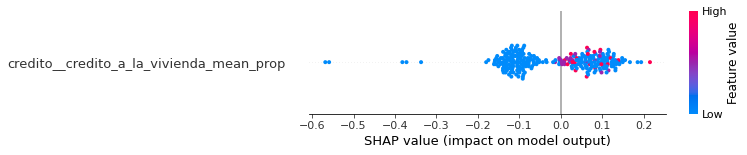

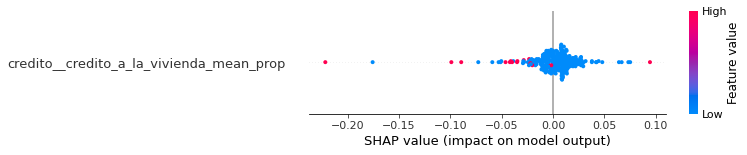

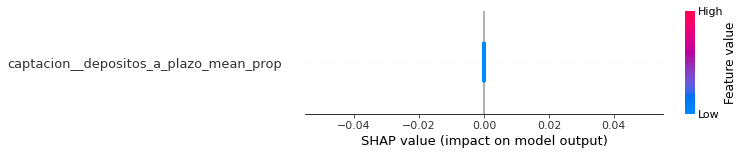

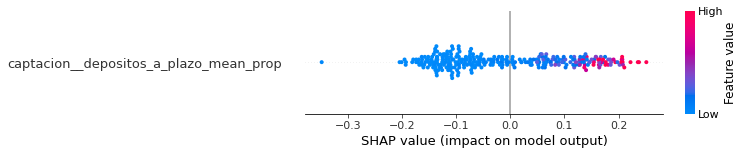

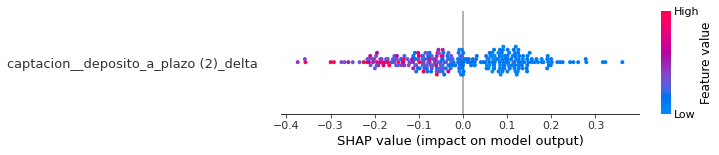

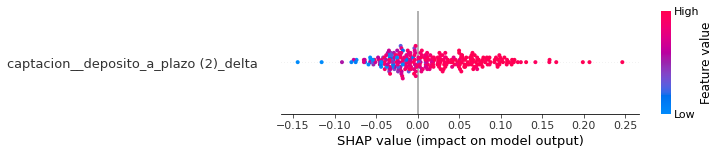

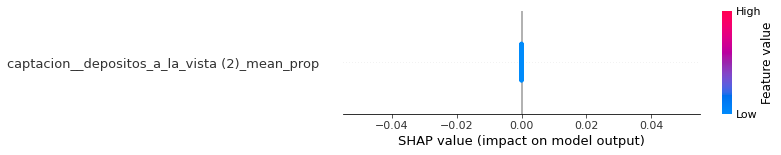

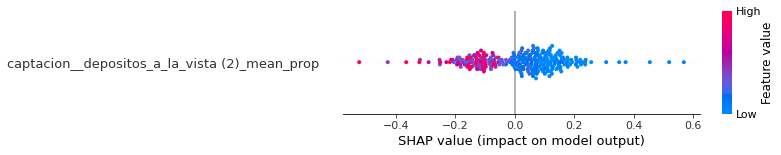

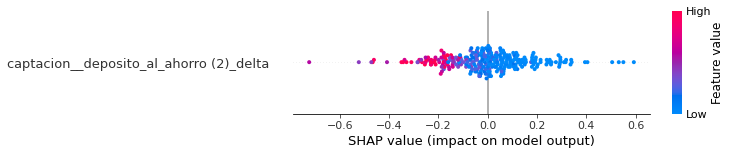

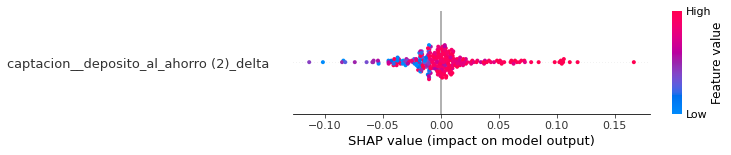

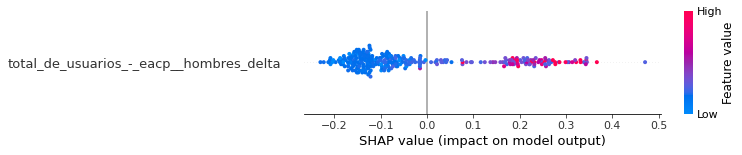

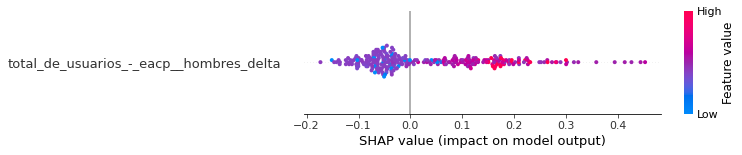

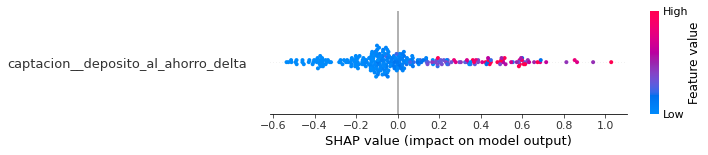

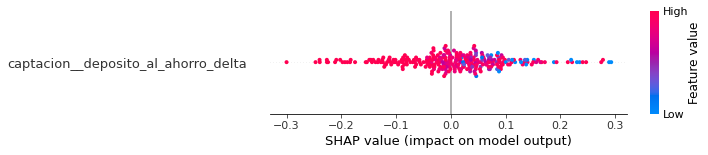

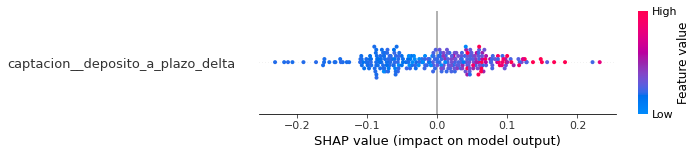

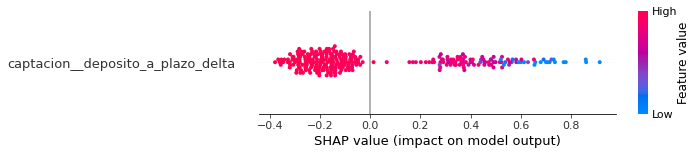

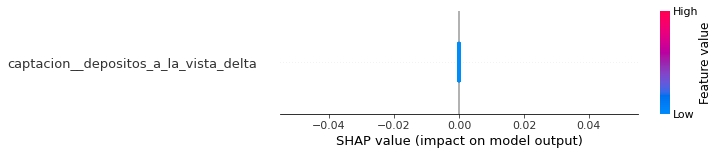

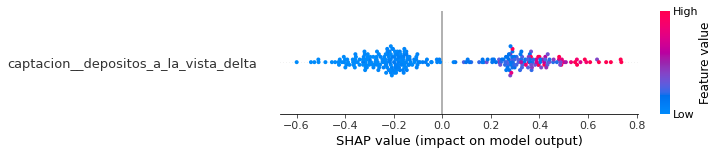

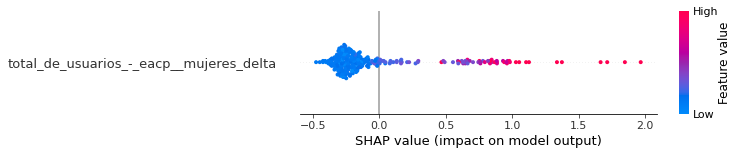

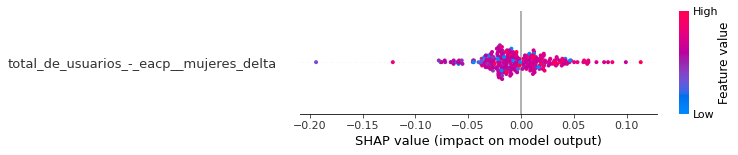

In [24]:
for f in feature_selection:
    for year, year_shap in shap_cache.items():
        shap.summary_plot(
            year_shap['f_shap_values'][[f]].values, 
            year_shap['X'][[f]])